# Agentic RAG with LangGraph and Pathway

This project demonstrates the integration of **Agentic Retrieval-Augmented Generation (RAG)** workflows using **LangGraph** and **Pathway**. Agentic RAG enables advanced information retrieval and synthesis, making it a powerful tool for building intelligent agents. The project leverages key technologies, libraries, and frameworks, including LangGraph, OpenAI, and other ecosystem tools, to create a modular and scalable solution.

## Key Components

- **LangGraph**: A graph-based framework designed for creating AI workflows with reusable components and integrations.
- **Pathway**: Enables orchestrating data workflows, optimizing retrieval processes, and facilitating scalability as well as Real Time indexing
- **OpenAI API**: Provides GPT-based capabilities for natural language understanding and generation.
- **SerpAPI and bs4**: Used for search and web scraping functionalities.
- **SQLite Checkpoints**: Facilitates lightweight, checkpoint-based storage during development and testing.

## Setup Instructions

Before running the project, ensure all dependencies are installed. The commands below will install the required libraries, including specific versions for compatibility. These dependencies include **LangChain**, **LangGraph**, **OpenAI**, and supporting libraries for data manipulation and API calls.

---

### Install Required Libraries

The following cell installs all necessary libraries to ensure the project runs smoothly. Run this cell to set up the environment.


In [ ]:
#Installation of libraries
!pip install langchain langchain-core langchain-tools typing-extensions serpapi bs4 pydantic openai tiktoken tqdm ipython
!pip install langchain_openai==0.2.8
!pip install openai==1.55.0
!pip install httpx==0.27.2
!pip install langgraph
!pip install langgraph-sdk
!pip install langgraph-checkpoint-sqlite
!pip install --upgrade google-search-results

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: langchain_openai
    Found existing installation: langchain-openai 0.2.11
    Uninstalling langchain-openai-0.2.11:
      Successfully uninstalled langchain-openai-0.2.11
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.5/389.5 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: htt

UsageError: Line magic function `%%capture` not found.


In [ ]:
%%capture --no-display
!pip install --prefer-binary pathway

## Secure Management of API Keys

This cell handles sensitive API keys securely using environment variables and runtime prompts. Keys are loaded via `os.getenv()` to prevent hardcoding and protect credentials. Missing keys are prompted at runtime using `getpass.getpass()` for added security.  

### Keys Managed:
- **Hugging Face Token**: Access to Hugging Face resources.
- **Google API & CSE**: Enables Google search.
- **SerpAPI**: Search engine integrations.
- **OpenAI API**: Powers GPT-based functionalities.
- **License Key**: Enables pathway's usage



In [ ]:
from google.colab import userdata
import os

# Fetch API keys securely from Colab userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_CSE_ID"] = userdata.get('GOOGLE_CSE_ID')
os.environ["SERP_API_KEY"] = userdata.get('SERP_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["LICENSE_KEY"] = userdata.get('LICENSE_KEY')

# Example: Access keys for further use
google_api_key = os.getenv("GOOGLE_API_KEY")
google_cse_id = os.getenv("GOOGLE_CSE_ID")
serp_api_key = os.getenv("SERP_API_KEY")
bing_api_key = os.getenv("BING_API_KEY",default = None)
openai_api_key = os.getenv("OPENAI_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY",default = None)
hf_token = os.getenv("HF_TOKEN")
license_key = os.getenv("LICENSE_KEY")

In [ ]:
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph,START,END
from IPython.display import Image, display
from bs4 import BeautifulSoup
from pydantic import BaseModel, Field
from serpapi import GoogleSearch
from langchain.tools import BaseTool
import requests
import time, random
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage
from typing import List, Tuple, Optional
from openai import OpenAI
import tiktoken
from tqdm import tqdm
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from serpapi import GoogleSearch
from google.colab import userdata
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# A data folder to upload your documents
!mkdir -p 'data/'

## Setting Up Pathway and Running the Vector Store Server

This section initializes Pathway, configures a vector store, and runs a server for embedding management and efficient data retrieval. The steps performed ensure smooth integration of data, embeddings, and querying capabilities.

### Key Steps:

1. **Pathway Initialization**:
   - Pathway is initialized using `pw.set_license_key()`. Ensure that the license key provided is valid for your project.

2. **Importing Required Dependencies**:
   - `VectorStoreServer` from Pathway's LLM xPacks: Manages vector-based queries.
   - `OpenAIEmbeddings`: Configured with the OpenAI API key to generate embeddings.
   - `CharacterTextSplitter`: Splits text into smaller chunks for preprocessing.

3. **Reading Data**:
   - Data is streamed from the `./data` directory using Pathway’s file system reader.
   - The `with_metadata=True` option enables richer query capabilities by including metadata.

4. **Configuring the Vector Store Server**:
   - Host (`127.0.0.1`) and Port (`8666`) are set for the local server.
   - The server is configured with:
     - **Embedder**: OpenAI embeddings.
     - **Splitter**: Character-based text splitter for efficient chunking.

5. **Running the Server**:
   - The server is launched with caching enabled for better performance.
   - A filesystem-based cache (`./Cache`) is used for persistence.
   - Runs in threaded mode to handle multiple simultaneous requests.
   - Once running, the server is accessible locally at `http://127.0.0.1:8666`.

### Instructions:
- Confirm the Pathway license key is valid and updated.
- Ensure the OpenAI API key is correctly set and accessible.
- Verify the `./data` directory contains the required input files.
- Make sure the `./Cache` directory exists or will be created by the script.
- Check that the specified host and port are not in use by another process.

This setup integrates data preprocessing, embeddings generation, and efficient querying into a streamlined workflow.


In [ ]:
import pathway as pw
pw.set_license_key(license_key)

from pathway.xpacks.llm.vector_store import VectorStoreServer
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter

data = pw.io.fs.read(
    "./data",
    format="binary",
    mode="streaming",
    with_metadata=True,
)

embeddings = OpenAIEmbeddings(api_key=openai_api_key)
splitter = CharacterTextSplitter()

host = "127.0.0.1"
port = 8666

server = VectorStoreServer.from_langchain_components(
    data, embedder=embeddings, splitter=splitter
)
server.run_server(host, port=port, with_cache=True, cache_backend=pw.persistence.Backend.filesystem("./Cache"), threaded=True)

<Thread(VectorStoreServer, started 137594228143680)>

## Checking Initial Vector Store Statistics

This step connects to the running vector store server and retrieves the current statistics to check the status of indexed data.

### Key Steps:
1. **Connect to the Server**:
   - A `PathwayVectorClient` instance is created using the host and port defined earlier.
   - This establishes communication with the running vector store server.

2. **Retrieve Vector Store Statistics**:
   - `client.get_vectorstore_statistics()` fetches the current status of the vector store, including the number of indexed items and other metadata.
   - Initially, since no data has been uploaded, the statistics should indicate an empty store.

### Purpose:
- Demonstrate the server's state before any files are uploaded and indexed.
- Lay the groundwork for comparison after uploading a file in subsequent steps.

This provides a clear baseline for the dynamic indexing feature of the vector store.


In [ ]:
from langchain_community.vectorstores import PathwayVectorClient
client = PathwayVectorClient(host=host, port=port)
client.get_vectorstore_statistics()

{'file_count': 0, 'last_modified': None, 'last_indexed': None}

###VectorStatistics After uploading the file


In [ ]:
client.get_vectorstore_statistics()

{'file_count': 1, 'last_modified': 1733490543, 'last_indexed': 1733490550}

In [ ]:
llm = ChatOpenAI(api_key = openai_api_key,temp = 0)
retr= client.as_retriever() # Using our pathway vectorclient in-order to retrieve relevant chunks

## Defining the LangGraph Flow: Initializing Graph State

This step sets the foundation for the LangGraph flow by defining the structure of the `graph_state`, which serves as a shared data model for the graph nodes. This state will be updated and passed through different nodes of the graph to manage the workflow.

### Key Steps:
1. **Define the Graph State**:
   - A custom `TypedDict` class, `graph_state`, is created to outline the structure of the state.
   - The state consists of:
     - `question`: A string representing the user’s query or prompt.
     - `generation`: A string to hold generated content (e.g., answers, responses).
     - `documents`: A list of `Document` objects representing retrieved or relevant documents.

2. **Purpose**:
   - Establish a standard structure for managing data across nodes.
   - Facilitate the flow of information between different components of the LangGraph workflow.

This marks the beginning of the LangGraph flow, where subsequent nodes will use and modify this state to process queries and generate meaningful results.


In [ ]:
class graph_state(TypedDict):
    question : str
    generation : str
    documents : list[Document]

### Installing Dependencies for Guardrails AI Implementation

This cell installs the necessary dependencies for using **Guardrails AI**, a framework designed to improve the reliability, safety, and trustworthiness of AI-generated outputs.

#### About Guardrails AI
- **Purpose**: Guardrails AI helps ensure that AI systems behave as expected by validating their outputs against pre-defined rules. It provides robust support for handling edge cases, toxic content, and logical inconsistencies, making AI deployments safer and more predictable.
- **Use Case in This Project**: Guardrails is integrated to manage and validate the output of language models, focusing on mitigating risks associated with toxic or inappropriate content.

#### Installed Dependencies:
1. `guardrails-ai[api]`: Includes core Guardrails functionality with additional API support.
2. `tensorflow`: Supports underlying AI model operations.
3. `nltk`: Facilitates natural language processing tasks like tokenization and parsing.
4. `transformers`: Enables integration with state-of-the-art transformer-based models (e.g., GPT, BERT).
5. `detoxify`: Assists in detecting and mitigating toxic language in text data.
6. `guardrails-ai` (reinstalled for ensuring up-to-date integration).

#### Additional Configurations:
- `!guardrails configure`: Initializes Guardrails setup within the environment.
- `!guardrails hub install hub://guardrails/toxic_language`: Installs a pre-defined toxic language detection policy from the Guardrails Hub for ensuring content safety.


In [ ]:
!pip install "guardrails-ai[api]"
!pip install tensorflow
!pip install nltk
!pip install transformers
!pip install detoxify
!pip install guardrails-ai
!guardrails configure
!guardrails hub install hub://guardrails/toxic_language

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.8/227.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.1
    Uninstalling protobuf-5.29.1:
      Successfully uninstalled protobuf-5.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.28.2 requires protobuf<6.0,>=5.0, but you have protobuf 4.25.5 which is incompatible.
  Using cached protobuf-5.29.1-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.29.1-cp38-abi3-manylinux2014_x86_64.whl (319 kB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2751, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __get

### Node: Guardrail Compliance Check and State Transition

#### **Functionality**
This node uses **Guardrails AI** to validate a user query against predefined compliance policies, specifically detecting toxic language. It defines functions to check compliance and determine the next state in the graph.

---

#### **Code Components**

1. **Compliance Output Structure**:
   - `GuardrailCheck1`: A Pydantic model defining a structured output for validation with a binary score (`yes` or `no`).

2. **Guardrails Validators**:
   - Applies the `ToxicLanguage` validator with a threshold of `0.5`.
   - Uses `sentence` as the validation method.
   - On failure, raises an exception (`on_fail="exception"`).

3. **Guardrail Check Function** (`guardrail_check`):
   - **Input**:
     - `state` (of type `graph_state`): A dictionary containing the current graph state, including the `question` to be validated.
   - **Process**:
     - Validates the input query using Guard.
     - On successful validation, updates the graph state and continues processing.
     - On failure, returns an error message and halts further processing.
   - **Output**:
     - On success: `{"generation": [], "question": ques}`
     - On failure: `{"generation": a, "question": ques}` where `a` is a predefined error message.

4. **State Transition Function** (`decide_guardrail`):
   - **Input**:
     - `state`: Current graph state, including the `generation` field indicating validation results.
   - **Conditional Logic**:
     - If `generation` is empty (no violations), returns `"fine"`.
     - Otherwise, returns `"inappropriate_query"`.
   - **Output**:
     - `"fine"`: For compliant queries.
     - `"inappropriate_query"`: For non-compliant queries.

---

#### **Purpose in the Workflow**
- Ensures user input complies with project policies by detecting and handling toxic or inappropriate language.
- Dynamically determines the next graph state based on the validation results, enabling appropriate flow control in the pipeline.


In [ ]:
from guardrails import Guard
from guardrails.hub import ToxicLanguage, GibberishText
from pydantic import BaseModel, Field
from typing import TypedDict

# Define your compliance output structure
class GuardrailCheck1(BaseModel):
    score: str = Field(description="Binary score indicating compliance. 'yes' if the query complies with policy, 'no' otherwise.")

# Create a Guard instance and apply multiple validators
guard = Guard().use_many(
    ToxicLanguage(threshold=0.5, validation_method="sentence", on_fail="exception"),
)

# Define the guardrail check function
def guardrail_check(state: graph_state):
    ques = state["question"]

    try:
        # Validate the input using Guard
        guard.validate(ques)
        print("Validation successful: Query is fine.")

        # Update the graph state for a valid query
        # state["guardrail_output"] = ""
        return {"generation":[],"question":ques}  # Continue processing
    except Exception as e:  # Catch any validation error from Guard
        # Handle validation failures and set the guardrail output
        print(f"Inappropriate query detected: {str(e)}")
        a = "I'm sorry, I cannot respond to that kind of request. Let's keep it respectful."
        return {"generation":a,"question":ques}  # End state or alternative flow

# Function to determine the next state based on guardrail output
def decide_guardrail(state: graph_state):
    guardrail_results = state['generation']

    if not guardrail_results:  # No violations
        return "fine"  # Ensure 'fine' is a defined state
    else:  # Print or log the state transition
        return "inappropriate_query"  # Ensure this state is handled in your graph
from guardrails import Guard
from guardrails.hub import ToxicLanguage, GibberishText
from pydantic import BaseModel, Field
from typing import TypedDict

# Define your compliance output structure
class GuardrailCheck1(BaseModel):
    score: str = Field(description="Binary score indicating compliance. 'yes' if the query complies with policy, 'no' otherwise.")

# Create a Guard instance and apply multiple validators
guard = Guard().use_many(
    ToxicLanguage(threshold=0.5, validation_method="sentence", on_fail="exception"),
)

# Define the guardrail check function
def guardrail_check(state: graph_state):
    ques = state["question"]

    try:
        # Validate the input using Guard
        guard.validate(ques)
        print("Validation successful: Query is fine.")

        # Update the graph state for a valid query
        # state["guardrail_output"] = ""
        return {"generation":[],"question":ques}  # Continue processing
    except Exception as e:  # Catch any validation error from Guard
        # Handle validation failures and set the guardrail output
        print(f"Inappropriate query detected: {str(e)}")
        a = "I'm sorry, I cannot respond to that kind of request. Let's keep it respectful."
        return {"generation":a,"question":ques}  # End state or alternative flow

# Function to determine the next state based on guardrail output
def decide_guardrail(state: graph_state):
    guardrail_results = state['generation']

    if not guardrail_results:  # No violations
        return "fine"  # Ensure 'fine' is a defined state
    else:  # Print or log the state transition
        return "inappropriate_query"  # Ensure this state is handled in your graph


### Node: Query Classification

#### **Functionality**
Classifies user queries into:
1. **Retrieval-Based**: Requires external data or detailed information.
2. **Conversational/Lifestyle-Based**: Answerable using general knowledge.

#### **Input**
- **state** (`graph_state`): Contains `"question"` (user's query).

#### **Output**
- Retrieval-Based: `{ "generation": [], "question": <user query> }`
- Conversational: `{ "generation": <classification result>, "question": <user query> }`

#### **Steps**
1. **Classification**: Uses `isformal_doc_llm` with prompts to label the query as `"no"` (retrieval) or `"yes"` (conversational).
2. **Decision**:
   - **`isformal_check`**: Determines the output format based on classification.
   - **`decide_isformal`**: Identifies the query type for further processing.
3. **Response**: **`formal_llm`** generates conversational responses if applicable.

#### **Purpose**
Directs queries along appropriate processing paths for accurate and relevant responses.


In [ ]:
class isformal_prompt(BaseModel):
    score_: str = Field(description="Indicates the query type. 'no' for retrieval-based-queries, 'yes' for formal conversational queries")

isformal_doc_llm = llm.with_structured_output(isformal_prompt)

isformal_system_message = """
Your task is to classify the user's query into one of two categories based on its information requirements:

    Retrieval-Based Query:
        Requires specific information, external data, or analysis from documents, databases, or other sources to provide an accurate answer.
        Includes queries related to technical, domain-specific topics (e.g., technology, finance, science) or detailed factual questions.
        Examples:
            'How does Alphabet’s AI strategy aim to empower individuals and industries?'
            'What are the global trends in renewable energy adoption for 2024?'

    Conversational/Lifestyle-Based Query:
        Can be answered without retrieval, using general knowledge or conversational insights.
        Includes queries that are lifestyle-focused, advice-oriented, or casual in nature.
        Examples:
            'What’s the best way to stay productive while working from home?'
            'How do I prepare for a weekend camping trip?'

Instructions:

    If the query is retrieval-based, respond with: "no".
    If the query is conversational/lifestyle-based, respond with: "yes".
    Use clear reasoning to handle ambiguous cases. If a query could be answered using general insights but clearly benefits from document-specific retrieval, default to "Retrieval".

"""
isformal_documents_prompt = "User's question: {question}"


def isformal_check(state:graph_state):
    ques = state["question"]
    prmpt = isformal_documents_prompt.format(question=ques)
    sc = isformal_doc_llm.invoke(
            [
                (SystemMessage(content=isformal_system_message)),
                (HumanMessage(content=prmpt))
            ]
      )
    grade_ = sc.score_
    if grade_=="no":
        return {"generation":[],"question":ques}
    else:
        return {"generation":sc.score_,"question":ques}

def decide_isformal(state:graph_state):
    gener = state["generation"]
    if not gener:
        return "information related"
    else:
        return "formal"

# formal_prompt = """you are a general assistant who handles formal questions or questions related to the user's lifestyle or general conversation.
# Please handle it politely, professionally, and appropriately, providing clear and helpful responses tailored to the context of the question.
# Question : {question}
# """


def formal_llm(state:graph_state):
    question = state["question"]
    gener = llm.invoke([HumanMessage(content=question)])
    return {"generation":gener,"question":question}

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter

class ComplexSimilaritySearch:
    def __init__(self, corpus, embedding_model="all-MiniLM-L6-v2", tfidf_weight=0.3, length_weight=0.2):
        """
        Initialize the Complex Similarity Search class.

        Parameters:
        - corpus: List of documents.
        - embedding_model: Pre-trained embedding model for semantic encoding.
        - tfidf_weight: Weightage for the TF-IDF score.
        - length_weight: Weightage for document length normalization.
        """
        self.corpus = corpus
        self.model = SentenceTransformer(embedding_model)
        self.embeddings = self._generate_embeddings(corpus)
        self.tfidf_vectorizer = TfidfVectorizer()
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(corpus)
        self.tfidf_weight = tfidf_weight
        self.length_weight = length_weight

    def _generate_embeddings(self, texts):
        """
        Generate semantic embeddings for the corpus.
        """
        return self.model.encode(texts, show_progress_bar=True)

    def _compute_length_score(self, query):
        """
        Compute length normalization score for each document.
        """
        query_length = len(query.split())
        doc_lengths = np.array([len(doc.split()) for doc in self.corpus])
        length_scores = 1 - np.abs(doc_lengths - query_length) / max(doc_lengths)
        return length_scores

    def _compute_tfidf_score(self, query):
        """
        Compute TF-IDF relevance score for the query.
        """
        query_vector = self.tfidf_vectorizer.transform([query])
        scores = (self.tfidf_matrix @ query_vector.T).toarray().flatten()
        return scores / np.max(scores)  # Normalize scores

    def retrieve_top_k(self, query, k=5):
        """
        Retrieve the top-k documents based on the combined similarity score.

        Parameters:
        - query: Query string.
        - k: Number of top documents to retrieve.

        Returns:
        - List of tuples (document, combined_similarity_score).
        """
        query_embedding = self.model.encode([query])
        cosine_scores = cosine_similarity(query_embedding, self.embeddings).flatten()
        tfidf_scores = self._compute_tfidf_score(query)
        length_scores = self._compute_length_score(query)

        # Combined score (weighted aggregation)
        combined_scores = (
            cosine_scores
            + self.tfidf_weight * tfidf_scores
            + self.length_weight * length_scores
        )

        # Retrieve top-k results
        top_k_indices = np.argsort(combined_scores)[::-1][:k]
        results = [(self.corpus[i], combined_scores[i]) for i in top_k_indices]
        return results

### Node: Source Planning and Document Filtering

#### **Functionality**
This node retrieves contextually relevant documents based on the user query and filters them for relevance using a custom similarity search and a document grading mechanism.

#### **Input**
- **state** (`graph_state`): Contains:
  - `"question"`: The user’s query.

#### **Output**
1. From `source_planner`:
   - **`documents`**: Top-k relevant documents.
   - **`question`**: The user’s query.
2. From `grade_document`:
   - **`documents`**: Filtered documents graded as relevant.
   - **`question`**: The user’s query.
3. From `decide_where_to_go`:
   - **`web_search`**: If no relevant documents are found.
   - **`go_on`**: If relevant documents are available.

#### **Steps**
1. **Document Retrieval (`source_planner`)**:
   - Uses `retr.invoke` to fetch raw context.
   - Splits the context into manageable chunks with `RecursiveCharacterTextSplitter`.
   - Performs similarity search via `ComplexSimilaritySearch` to retrieve top-k documents relevant to the query.

2. **Document Grading (`grade_document`)**:
   - Each retrieved document is evaluated using `grade_doc_llm`:
     - Grades documents as `"yes"` or `"no"` based on their relevance to the query.
     - Filters out irrelevant documents.

3. **Routing Decision (`decide_where_to_go`)**:
   - Directs the flow:
     - `"web_search"` if no relevant documents remain.
     - `"go_on"` to proceed if relevant documents are present.

#### **Purpose**
Ensures precise and contextually relevant document retrieval while filtering out irrelevant results to enhance the quality of downstream processing.


In [ ]:
def source_planner(state: graph_state):
    question = state["question"]
    context = retr.invoke(question)
    split = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
    doc = split.split_documents(context)
    page_contents = [doc[i].page_content for i in range(len(doc))]
    similarity_search = ComplexSimilaritySearch(page_contents)
    top_k_results = similarity_search.retrieve_top_k(question, k=3)
    rel_doc = [top_k_results[i][0] for i in range(len(top_k_results))]
    return {"documents":rel_doc,"question":question}


class grade_doc(BaseModel):
    score : str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

grade_doc_llm = llm.with_structured_output(grade_doc)
grade_systm_msg = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"

def grade_document(state:graph_state):
    ques = state["question"]
    docs = state["documents"]

    filter_doc = []
    for d in docs:
        prmpt = grade_documents_prompt.format(document=d,question=ques)
        sc = grade_doc_llm.invoke(
            [
                (SystemMessage(content=grade_systm_msg)),
                (HumanMessage(content=prmpt))
            ]
        )
        grade = sc.score
        if grade == "yes":
            filter_doc.append(d)
        else:
            continue
    return {"documents":filter_doc,"question":ques}

def decide_where_to_go(state:graph_state):
    filter_docs = state['documents']
    if not filter_docs:
        return "web_search"
    else:
        return "go_on"


In [ ]:
class WebSearchTool(BaseTool, BaseModel):
    """
    Perform web searches using Google Custom Search API, SERP API, and a fallback mechanism.
    Logs which API is being used for better traceability.
    """
    name: str = "WebSearch"
    description: str = "Perform a web search and return URLs of the results."

    google_api_key: str = Field(..., description="API key for Google Custom Search API")
    google_cse_id: str = Field(..., description="Google Custom Search Engine ID")
    serp_api_key: str = Field(..., description="API key for SERP API")
    active_api: str = Field(default=None, description="Currently active API")
    max_retries: int = Field(default=5, description="Maximum number of retries")
    max_backoff: int = Field(default=32, description="Maximum backoff time in seconds")

    def _perform_request_with_backoff(self, request_func, *args, **kwargs):
        """
        Perform a request with exponential backoff and jitter.
        """
        retry_delay = 1  # Initial delay in seconds
        for attempt in range(self.max_retries):
            try:
                return request_func(*args, **kwargs)
            except requests.RequestException as e:
                print(f"Attempt {attempt + 1} failed: {e}")
                if attempt == self.max_retries - 1:
                    raise # Re-raise the exception after max retries
                time.sleep(min(retry_delay + random.uniform(0, 1), self.max_backoff))  # Add jitter
                retry_delay = min(retry_delay * 2, self.max_backoff)  # Exponential backoff


    def _search_google(self, query: str):
        """Search using Google Custom Search API with retries."""
        self.active_api = "Google Custom Search API"
        print(f"Using {self.active_api}...")

        def google_request():
            url = "https://www.googleapis.com/customsearch/v1"
            params = {"q": query, "key": self.google_api_key, "cx": self.google_cse_id, "num": 5}
            response = requests.get(url, params=params)
            response.raise_for_status()
            return response.json()

        search_results = self._perform_request_with_backoff(google_request)
        return [item.get("link") for item in search_results.get("items", [])]

    def _search_serp(self, query: str):
        """Search using SERP API with retries."""
        self.active_api = "SERP API"
        print(f"Using {self.active_api}...")

        def serp_request():
            params = {
                "q": query,
                "api_key": self.serp_api_key,
                "num": 5
            }
            search = GoogleSearch(params)
            search_results = search.get_dict()  # Retrieve SERP API results as a dictionary
            if "error" in search_results:
                raise Exception(f"SERP API Error: {search_results['error']}")
            return search_results

        search_results = self._perform_request_with_backoff(serp_request)
        return [item.get("link") for item in search_results.get("organic_results", [])]

    def _run(self, query: str):
        """Run the search with fallback mechanisms and log the API in use."""
        fallback_methods = [self._search_serp, self._search_google]
        for attempt, method in enumerate(fallback_methods):
            try:
                print(f"Attempt {attempt}: Trying method: {method.__name__}")
                results = method(query)
                print(f"Search successful with {self.active_api}.")
                return results
            except Exception as e:
                print(f"Error using {self.active_api}: {e}")
        print("All API search methods failed.")
        return []

    def _arun(self, query: str):
        raise NotImplementedError("WebSearchTool does not support async mode.")

In [ ]:
def preprocess_scraped_content(html_content, query_keywords):
    """
    Extract relevant content like lists and paragraphs from the HTML content,
    focusing on query-related sections.
    """
    soup = BeautifulSoup(html_content, "html.parser")

    # Extract list items (e.g., from <ul>, <ol>)
    lists = soup.find_all(["ul", "ol"])
    list_text = " ".join(
        li.get_text(strip=True) for ul in lists for li in ul.find_all("li") if any(kw in li.get_text(strip=True).lower() for kw in query_keywords)
    )

    # Extract paragraphs and filter for query keywords
    paragraphs = soup.find_all("p")
    paragraph_text = " ".join(
        p.get_text(strip=True) for p in paragraphs if any(kw in p.get_text(strip=True).lower() for kw in query_keywords)
    )

    # Combine lists and paragraphs
    clean_text = list_text + " " + paragraph_text

    # Further clean the combined text
    clean_text = " ".join(clean_text.split())

    return clean_text

class WebScrapingTool(BaseTool):
    name: str = "WebScraping"
    description: str = "Scrape text content from a list of URLs."

    def _run(self, urls: list, query_keywords: list):
        print("Scraping web pages...")
        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/91.0.4472.124 Safari/537.36"
            )
        }
        texts = []
        urls = urls[:1]
        for url in urls:
            try:
                response = requests.get(url, headers=headers, timeout=10)
                response.raise_for_status()
                clean_text = preprocess_scraped_content(response.content, query_keywords)  # Pass query keywords
                print(f"Cleaned content from {url[:50]}: {clean_text[:500]}...")  # Debugging
                texts.append(clean_text)
            except requests.RequestException as e:
                print(f"Skipping {url} due to error: {e}")
        return texts

    async def _arun(self, urls: list):
        raise NotImplementedError("WebScrapingTool does not support async mode.")

In [ ]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def get_chat_completion(messages, model='gpt-3.5-turbo'):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message.content

def tokenize(text: str) -> List[str]:
    encoding = tiktoken.encoding_for_model('gpt-3.5-turbo')
    return encoding.encode(text)


# This function chunks a text into smaller pieces based on a maximum token count and a delimiter.
def chunk_on_delimiter(input_string: str,
                       max_tokens: int, delimiter: str) -> List[str]:
    chunks = input_string.split(delimiter)
    combined_chunks, _, dropped_chunk_count = combine_chunks_with_no_minimum(
        chunks, max_tokens, chunk_delimiter=delimiter, add_ellipsis_for_overflow=True
    )
    if dropped_chunk_count > 0:
        print(f"warning: {dropped_chunk_count} chunks were dropped due to overflow")
    combined_chunks = [f"{chunk}{delimiter}" for chunk in combined_chunks]
    return combined_chunks


# This function combines text chunks into larger blocks without exceeding a specified token count. It returns the combined text blocks, their original indices, and the count of chunks dropped due to overflow.
def combine_chunks_with_no_minimum(
        chunks: List[str],
        max_tokens: int,
        chunk_delimiter="\n\n",
        header: Optional[str] = None,
        add_ellipsis_for_overflow=False,
) -> Tuple[List[str], List[int]]:
    dropped_chunk_count = 0
    output = []  # list to hold the final combined chunks
    output_indices = []  # list to hold the indices of the final combined chunks
    candidate = (
        [] if header is None else [header]
    )  # list to hold the current combined chunk candidate
    candidate_indices = []
    for chunk_i, chunk in enumerate(chunks):
        chunk_with_header = [chunk] if header is None else [header, chunk]
        if len(tokenize(chunk_delimiter.join(chunk_with_header))) > max_tokens:
            print(f"warning: chunk overflow")
            if (
                    add_ellipsis_for_overflow
                    and len(tokenize(chunk_delimiter.join(candidate + ["..."]))) <= max_tokens
            ):
                candidate.append("...")
                dropped_chunk_count += 1
            continue
        extended_candidate_token_count = len(tokenize(chunk_delimiter.join(candidate + [chunk])))
        if extended_candidate_token_count > max_tokens:
            output.append(chunk_delimiter.join(candidate))
            output_indices.append(candidate_indices)
            candidate = chunk_with_header
            candidate_indices = [chunk_i]
        else:
            candidate.append(chunk)
            candidate_indices.append(chunk_i)
    if (header is not None and len(candidate) > 1) or (header is None and len(candidate) > 0):
        output.append(chunk_delimiter.join(candidate))
        output_indices.append(candidate_indices)
    return output, output_indices, dropped_chunk_count

def summarize(text: str,
              detail: float = 0,
              model: str = 'gpt-4-turbo',
              additional_instructions: Optional[str] = None,
              minimum_chunk_size: Optional[int] = 500,
              chunk_delimiter: str = ".",
              summarize_recursively=False,
              verbose=False):
    """
    Summarizes a given text by splitting it into chunks, each of which is summarized individually.
    The level of detail in the summary can be adjusted, and the process can optionally be made recursive.

    Parameters:
    - text (str): The text to be summarized.
    - detail (float, optional): A value between 0 and 1 indicating the desired level of detail in the summary.
      0 leads to a higher level summary, and 1 results in a more detailed summary. Defaults to 0.
    - model (str, optional): The model to use for generating summaries. Defaults to 'gpt-3.5-turbo'.
    - additional_instructions (Optional[str], optional): Additional instructions to provide to the model for customizing summaries.
    - minimum_chunk_size (Optional[int], optional): The minimum size for text chunks. Defaults to 500.
    - chunk_delimiter (str, optional): The delimiter used to split the text into chunks. Defaults to ".".
    - summarize_recursively (bool, optional): If True, summaries are generated recursively, using previous summaries for context.
    - verbose (bool, optional): If True, prints detailed information about the chunking process.

    Returns:
    - str: The final compiled summary of the text.

    The function first determines the number of chunks by interpolating between a minimum and a maximum chunk count based on the `detail` parameter.
    It then splits the text into chunks and summarizes each chunk. If `summarize_recursively` is True, each summary is based on the previous summaries,
    adding more context to the summarization process. The function returns a compiled summary of all chunks.
    """
    assert 0 <= detail <= 1
    max_chunks = len(chunk_on_delimiter(text, minimum_chunk_size, chunk_delimiter))
    min_chunks = 1
    num_chunks = int(min_chunks + detail * (max_chunks - min_chunks))

    document_length = len(tokenize(text))
    chunk_size = max(minimum_chunk_size, document_length // num_chunks)
    text_chunks = chunk_on_delimiter(text, chunk_size, chunk_delimiter)
    if verbose:
        print(f"Splitting the text into {len(text_chunks)} chunks to be summarized.")
        print(f"Chunk lengths are {[len(tokenize(x)) for x in text_chunks]}")

    # set system message
    system_message_content = "Rewrite this text in summarized form."
    if additional_instructions is not None:
        system_message_content += f"\n\n{additional_instructions}"

    accumulated_summaries = []
    for chunk in tqdm(text_chunks):
        if summarize_recursively and accumulated_summaries:
            accumulated_summaries_string = '\n\n'.join(accumulated_summaries)
            user_message_content = f"Previous summaries:\n\n{accumulated_summaries_string}\n\nText to summarize next:\n\n{chunk}"
        else:
            user_message_content = chunk

        messages = [
            {"role": "system", "content": system_message_content},
            {"role": "user", "content": user_message_content}
        ]

        response = get_chat_completion(messages, model=model)
        accumulated_summaries.append(response)


    final_summary = '\n\n'.join(accumulated_summaries)

    return final_summary

### Node: Web Search and Context Generation

#### **Functionality**
This node performs a web search using a custom-built `WebSearchTool` to retrieve, scrape, and summarize relevant online content based on the user’s query. It generates a contextually rich response using the retrieved data.

#### **Input**
- **state** (`graph_state`): Contains:
  - `"question"`: The user’s query.

#### **Output**
- **`documents`**: `"Web Search"` (indicating web-based sources).
- **`question`**: The user’s query.
- **`generation`**: A generated response using summarized web search results.

#### **Steps**
1. **Web Search**:
   - Uses `WebSearchTool` configured with:
     - `GOOGLE_API_KEY`, `GOOGLE_CSE_ID`, and `SERP_API_KEY`.
   - Retrieves search results for the user’s query.

2. **Web Scraping**:
   - Passes search results to `WebScrapingTool` to extract relevant content from the retrieved web pages.

3. **Summarization**:
   - Combines the scraped texts and summarizes them into a coherent context string using a summarization tool.

4. **Contextual Response Generation**:
   - Formats the summarized content into a predefined prompt (`rag_prompt`).
   - Invokes the language model (`llm`) to generate a response based on the summarized content.

#### **Purpose**
Provides an accurate and up-to-date response by leveraging external web resources, ensuring the system can handle queries requiring real-time or external information.


In [ ]:
rag_prompt ="""You are a language editor ensuring correct spelling and grammar.

Review the provided answer. Correct any spelling or grammatical mistakes, but do not change the meaning or content. Ensure that no abusive or inappropriate words are present in the text.

generated_answer: {generated_answer}

Corrected Answer:"""

def web_search(state: graph_state):
    query = state['question']
    web_search_tool = WebSearchTool(
            google_api_key=GOOGLE_API_KEY,
            google_cse_id=GOOGLE_CSE_ID,
            serp_api_key=SERP_API_KEY
            )
    web_search_results = web_search_tool._run(query)
    web_scraping_tool = WebScrapingTool()
    scraped_texts = web_scraping_tool._run(web_search_results, query)
    context = str(summarize("\n".join(scraped_texts)))
    prompt = rag_prompt.format(generated_answer=context)
    generate = llm.invoke([HumanMessage(content=prompt)])
    return {"documents":"Web Search","question":query,"generation":generate}


### Classes: Leader-Analyst and Conversational Chain

#### **Overview**
These classes orchestrate a hierarchical interaction between a **Leader** and multiple **Analysts** to process a user query. The **Leader** divides tasks, synthesizes results, and ensures cohesive communication. Analysts provide granular insights for assigned subtasks.

---

#### **Leader Class**
- **Purpose**: Coordinates task division and result unification.
- **Key Functions**:
  1. **`divide_task(query)`**:
     - Divides the query into two subtasks.
     - Returns `subtask_1` and `subtask_2`.
  2. **`unify_responses(response_1, response_2)`**:
     - Merges analyst responses into a coherent output.
  3. **`follow_up_required(final_response, query, context)`**:
     - Determines if additional analysis is necessary.
     - Returns a binary "Yes" or "No".
  4. **`generate_follow_up_new(query, subtask_1, subtask_2)`**:
     - Creates new subtasks when further analysis is required.

---

#### **Analyst Process**
- **Purpose**: Analyzes subtasks using provided document context.
- **Function**:
  - Uses a predefined `analyst_prompt_template` to structure the analysis.
  - Suggests follow-up questions or provides a conclusion based on the context.

---

#### **Conversational Chain**
- **Purpose**: Facilitates communication between the Leader and Analysts to process queries iteratively.
- **Key Steps**:
  1. **Task Division**:
     - The Leader divides the main query into subtasks.
  2. **Subtask Processing**:
     - Analysts analyze subtasks using relevant documents and generate responses.
  3. **Response Unification**:
     - The Leader combines analyst responses into a unified output.
  4. **Follow-Up Management**:
     - Determines if additional subtasks are needed and repeats the process as required.

---

#### **Use Case**
- Ideal for handling complex queries requiring iterative analysis, task decomposition, and structured collaboration between agents.


In [ ]:
# Analyst Prompt Template
analyst_prompt_template = """
You are an Analyst. Your task is to analyze the following query using the provided document context:

Query: {query}
Document Context: {context}

Provide a informative response based on the query. If you think further clarification or information is needed, suggest a follow-up question to ask the next analyst. If no follow-up is needed, leave it blank or provide a conclusion to end the conversation.
"""

# Leader Prompt Template (Updated)
leader_prompt_template = """
You are the Leader. Your task is to divide the main task into two subtasks and assign each subtask to one of the Analysts. After receiving the responses from both Analysts, unify their answers and provide the final output.

Here are the responses from Analyst 1 and Analyst 2:

Analyst 1 Response: {response_1}
Analyst 2 Response: {response_2}

Your task:
1. Based on the responses, unify both answers into a coherent final output.
2. Summarize both responses, ensuring the conversation flows logically.
3. The final response should incorporate the insights from both analysts and conclude the task.
"""


# Function to process query with relevant documents
def analyst_process(query, relevant_documents):
    context = "\n\n".join(
    d.page_content if hasattr(d, "page_content") else str(d) for d in relevant_documents
    )

    # Create prompt and run the analysis
    analyst_prompt = analyst_prompt_template.format(query=query, context=context)
    response = ChatOpenAI(temperature=0.0).invoke([HumanMessage(content=analyst_prompt)])
    return response.content  # Return the generated response


class LeaderChain:
    def __init__(self, model):
        self.model = model
        self.prompt_template = PromptTemplate(
            input_variables=["response_1", "response_2"],
            template=leader_prompt_template
        )

    def divide_task(self, query):
        divide_prompt = f"Divide the following query into two distinct subtasks:\n\nQuery: {query}\n\nProvide the subtasks in this format:\nSubtask 1: \"first task\"\nSubtask 2: \"second task\""
        divide_message = HumanMessage(content=divide_prompt)

        # Invoke the model to get the response
        divide_response = self.model.invoke([divide_message])

        # Extract subtasks from the LLM's response
        response_content = divide_response.content
        try:
            subtask_1 = response_content.split("Subtask 1:")[1].split("Subtask 2:")[0].strip().strip("\"")
            subtask_2 = response_content.split("Subtask 2:")[1].strip().strip("\"")
        except (IndexError, ValueError):
            raise ValueError("Failed to parse subtasks from the LLM's response.")

        return subtask_1, subtask_2

    def generate_follow_up(self, response_1, response_2):
        # Prepare the prompt for the leader with the two responses
        prompt = self.prompt_template.format(response_1=response_1, response_2=response_2)

        # Generate the leader's response (including follow-up or final output)
        leader_message = HumanMessage(content=prompt)
        leader_response = self.model.invoke([leader_message])

        return leader_response.content

    def unify_responses(self, response_1, response_2):
        # Prompt the LLM to unify the responses
        unify_prompt = f"Unify the following two responses into a final, cohesive response:\n\nResponse 1: {response_1}\n\nResponse 2: {response_2}\n\nProvide the unified response below."
        unify_message = HumanMessage(content=unify_prompt)

        # Invoke the model to get the unified response
        unify_response = self.model.invoke([unify_message])

        return unify_response.content

    def follow_up_required(self, final_response, query, context):
        prompt_if_follow_up = f"""Based on the provided query, context, and final response, determine if the query has been successfully answered. If the query is fully and accurately answered, output 'Yes.' If it is incomplete, inaccurate, or irrelevant, output 'No.'\n\nQuery: {query}\nContext: {context}\nFinal Response: {final_response}"""
        message_if_follow_up = HumanMessage(content=prompt_if_follow_up)
        response_if_follow_up = self.model.invoke([message_if_follow_up])
        return response_if_follow_up.content.strip() == 'Yes'

    def generate_follow_up_new(self, query, subtask_1, subtask_2):
        divide_prompt = f"Divide the following query into two new subtasks that are different from the existing ones:\n\nExisting Subtask 1: \"{subtask_1}\"\nExisting Subtask 2: \"{subtask_2}\"\n\nQuery: {query}\n\nProvide the new subtasks in this format:\nSubtask 1: \"first task\"\nSubtask 2: \"second task\""
        divide_message = HumanMessage(content=divide_prompt)

        # Invoke the model to get the response
        divide_response = self.model.invoke([divide_message])

        # Extract new subtasks from the LLM's response
        response_content = divide_response.content
        try:
            new_subtask_1 = response_content.split("Subtask 1:")[1].split("Subtask 2:")[0].strip().strip("\"")
            new_subtask_2 = response_content.split("Subtask 2:")[1].strip().strip("\"")
        except (IndexError, ValueError):
            raise ValueError("Failed to parse new subtasks from the LLM's response.")

        return new_subtask_1, new_subtask_2


def conversational_chain(query, leader, retr):
    follow_up_queries = []  # Initialize follow-up queries list
    follow_up_responses = []
    final_response = ""

    # Leader divides the task into two subtasks

    print("Entering leader-analyst chain")
    subtask_1, subtask_2 = leader.divide_task(query)
    print(f"""Dividing query into 2 sub-tasks\n
    Subtask_1 : {subtask_1}\n
    Subtask_2 : {subtask_2}""")
    follow_up_queries.extend([subtask_1, subtask_2])

    context = []
    # context_2 = []

    # Process responses for both analysts
    for i, current_query in enumerate(follow_up_queries[:2]):  # Loop for the initial two subtasks
        relevant_documents = retr.get_relevant_documents(current_query)
        split = RecursiveCharacterTextSplitter(chunk_size=2000,chunk_overlap=200)
        doc = split.split_documents(relevant_documents)
        page_contents = [doc[i].page_content for i in range(len(doc))]
        similarity_search = ComplexSimilaritySearch(page_contents)
        top_k_results = similarity_search.retrieve_top_k(current_query, k=3)
        rel_doc = [top_k_results[i][0] for i in range(len(top_k_results))]
        context.extend(rel_doc)
        response = analyst_process(current_query, rel_doc)
        follow_up_responses.append(response)
        # response = analysts[i]({"query": current_query})
        # follow_up_responses.append(response['result'])

    # Unify responses if both analysts provided outputs
    if len(follow_up_responses) == 2:
        response_1, response_2 = follow_up_responses
        final_response = leader.unify_responses(response_1, response_2)

    # Check if a follow-up is required
    # context = [doc for resp in follow_up_responses for doc in resp.get('source_documents', [])]
    if leader.follow_up_required(final_response, query, context):
        print("Follow up required")
        follow_up_queries_2 = []
        follow_up_responses_2 = []

        # Generate new subtasks
        subtask_3, subtask_4 = leader.generate_follow_up_new(query, subtask_1, subtask_2)
        # print(f"""Dividing query further into 2 new sub-tasks\n
        # Subtask_3 : {subtask_3}\n
        # Subtask_4 : {subtask_4}""")
        follow_up_queries_2.extend([subtask_3, subtask_4])

        # Process the new subtasks
        for i, current_query in enumerate(follow_up_queries_2):
            relevant_documents = retr.get_relevant_documents(current_query)
            split = RecursiveCharacterTextSplitter(chunk_size=2000,chunk_overlap=200)
            doc = split.split_documents(relevant_documents)
            page_contents = [doc[i].page_content for i in range(len(doc))]
            similarity_search = ComplexSimilaritySearch(page_contents)
            top_k_results = similarity_search.retrieve_top_k(current_query, k=3)
            rel_doc = [top_k_results[i][0] for i in range(len(top_k_results))]
            context.extend(rel_doc)
            response = analyst_process(current_query, rel_doc)
            follow_up_responses_2.append(response)
            # response = analysts[i]({"query": current_query})
            # follow_up_responses_2.append(response['result'])

        # Unify the new set of responses
        if len(follow_up_responses_2) == 2:
            response_3, response_4 = follow_up_responses_2
            follow_up_leader_response = leader.unify_responses(response_3, response_4)
            final_response = leader.unify_responses(final_response, follow_up_leader_response)

    # Default fallback if no final response
    if not final_response:
        final_response = "No follow-up required. Conversation terminated."

    return {
        "follow_up_queries": follow_up_queries + follow_up_queries_2 if 'follow_up_queries_2' in locals() else follow_up_queries,
        "follow_up_responses": follow_up_responses + follow_up_responses_2 if 'follow_up_responses_2' in locals() else follow_up_responses,
        "final_response": final_response,
        "context": context
    }


In [ ]:
from langchain import PromptTemplate

In [ ]:
from langchain import PromptTemplate
leader_model = ChatOpenAI(temperature=0.0)
leader_chain = LeaderChain(leader_model)

### Node: Final Response Generation

#### **Functionality**
This node generates the final response by leveraging the **Conversational Chain** process and a predefined **RAG Prompt** for structured output. It integrates insights from iterative query analysis and context generation.

---

#### **Input**
- **state** (`graph_state`): Contains:
  - `"question"`: The user’s query.

---

#### **Output**
- **`documents`**: A concatenated string of all retrieved and processed context documents.
- **`question`**: The user’s query.
- **`generation`**: The final generated response.

---

#### **Steps**
1. **Query Processing**:
   - Passes the user query to the `conversational_chain` function, which coordinates task division, analysis, and unification through the **Leader-Analyst structure**.

2. **Contextual Prompting**:
   - Formats the final response from the `conversational_chain` into the `rag_prompt` for a structured and well-articulated output.

3. **Response Generation**:
   - Invokes the language model (`llm`) with the formatted prompt to generate the final response.

---

#### **Purpose**
Delivers a comprehensive, contextually rich, and polished final response by synthesizing all gathered insights, ensuring the user's query is addressed with precision and depth.


In [ ]:
lang_prompt ="""You are a language editor ensuring correct spelling and grammar.

Review the provided answer. Correct any spelling or grammatical mistakes, but do not change the meaning or content. Ensure that no abusive or inappropriate words are present in the text.

generated_answer: {generated_answer}

Corrected Answer:"""
def generate_response(state:graph_state):
    question = state["question"]
    result = conversational_chain(question,leader_chain,retr)
    prompt = lang_prompt.format(generated_answer=result["final_response"])
    generate = llm.invoke([HumanMessage(content=prompt)])
    return {"documents":' '.join(result["context"]),"question":question,"generation":generate}

### Node: Human-in-the-Loop (HITL)

#### **Functionality**
This node introduces a human feedback mechanism, allowing users to evaluate the generated response and refine the question if necessary. It enables iterative improvement of the query processing and ensures user satisfaction.

---

#### **Input**
- **state** (`graph_state`): Contains:
  - `"generation"`: The generated answer.
  - `"question"`: The original user query.

---

#### **Output**
- **`documents`**: Empty if a re-run is triggered.
- **`question`**: The updated question incorporating user feedback, or the original question if no changes are made.

---

#### **Steps**
1. **Response Presentation**:
   - Displays the generated response to the user.

2. **Feedback Collection**:
   - Asks the user if they are satisfied with the response (`yes` or `no`).
   - Handles invalid input gracefully by re-prompting.

3. **User Action**:
   - **If `yes`**: Marks the process as complete.
   - **If `no`**: Requests additional details or refinements to the query.
   - Updates the query with the additional information and re-runs the process.

---

#### **Decision Helper**
- **`decide_(state: graph_state)`**:
  - Checks the presence of relevant documents.
  - Routes to:
    - `"Re_run"`: If no documents are found.
    - `"lets_go"`: If relevant documents are available.

---

#### **Purpose**
Enhances system adaptability and accuracy by integrating human oversight, enabling query refinement, and ensuring the final response aligns with user expectations.


In [ ]:
def human_in_the_loop(state: graph_state):
    """
    Implements HITL logic to interact with the user, refine the question, and re-run if needed.
    """
    answer = state["generation"]
    question = state["question"]
    print(f"Generated Answer:\n{answer}")
    user_feedback = input("\nAre you satisfied with the answer? (yes/no): ").strip().lower()

    if user_feedback == "yes":
        print("-----END-----")
    elif user_feedback == "no":
        additional_info = input("\nPlease provide more details or refine the question: ").strip()
        updated_question = f"{question}. Additional Info: {additional_info}"

        print("---\nRe-running the process with updated question...\n---")
        return {"documents":[],"question":updated_question}
    else:
        print("Invalid input! Please respond with 'yes' or 'no'.")
        return human_in_the_loop(state)

def decide_(state: graph_state):
    found = state["documents"]
    if not found:
        return "Re_run"
    else:
        return "lets_go"

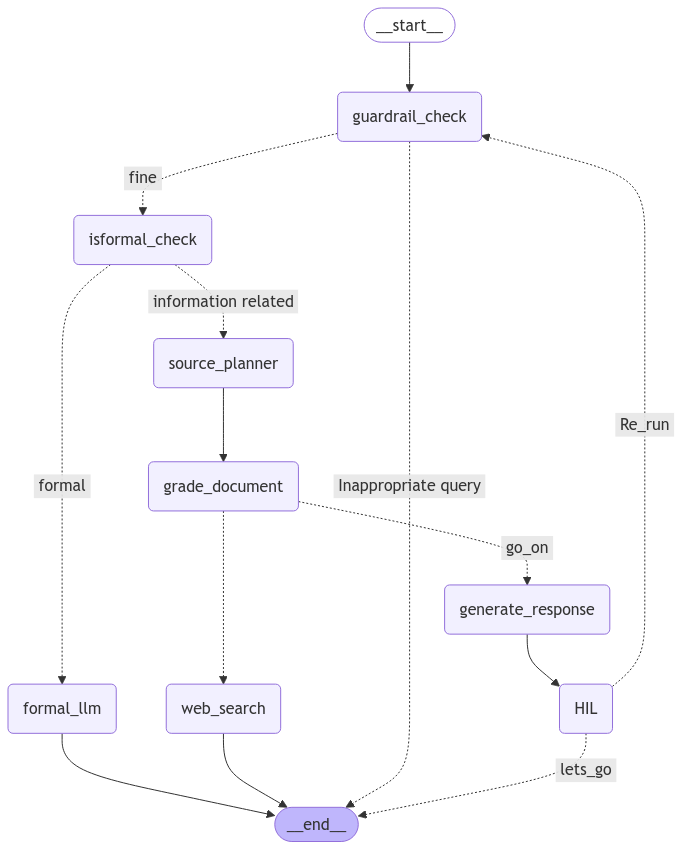

In [ ]:
flow = StateGraph(graph_state)
flow.add_node("guardrail_check",guardrail_check)
flow.add_node("isformal_check",isformal_check)
flow.add_node("formal_llm",formal_llm)
flow.add_node("source_planner",source_planner)
flow.add_node("grade_document",grade_document)
flow.add_node("web_search",web_search)
# flow.add_node("retrieve_document",retrieve_document)
flow.add_node("Leader_Analyst",generate_response)
flow.add_node("HIL",human_in_the_loop)

flow.add_edge(START,"guardrail_check")

flow.add_conditional_edges(
    "guardrail_check",
    decide_guardril,
    {
        "fine":"isformal_check",
        "Inappropriate query":END
    }

)

flow.add_conditional_edges(
    "isformal_check",
    decide_isformal,
    {
        "information related":"source_planner",
        "formal":"formal_llm",
    }
)

flow.add_edge("formal_llm",END)
flow.add_edge("source_planner","grade_document")

flow.add_conditional_edges(
    "grade_document",
    decide_where_to_go,
    {
        "web_search":"web_search",
        "go_on" : "Leader_Analyst"
    }
)

flow.add_edge("web_search",END)
flow.add_edge("Leader_Analyst", "HIL")

flow.add_conditional_edges(
    "HIL",
    decide_,
    {
        "lets_go": END,
        "Re_run": "guardrail_check",
    }
)

flow = flow.compile()

display(Image(flow.get_graph().draw_mermaid_png()))

In [ ]:
question = "How does Alphabet’s AI strategy aim to empower individuals and industries?"
ans = flow.invoke({"question":question})

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Entering leader-analyst chain
Dividing query into 2 sub-tasks

    Subtask_1 : Research Alphabet's AI strategy

    Subtask_2 : Analyze how Alphabet's AI strategy empowers individuals and industries


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

{'question': 'How does Alphabet’s AI strategy aim to empower individuals and industries?',
 'generation': AIMessage(content="Alphabet's AI strategy is centered around advancing the frontier of AI to develop more capable and useful AI every day. AI is already a key component of Google's core products, benefiting billions of people and businesses globally. Alphabet sees AI as essential to fulfilling its mission and is dedicated to bringing breakthrough AI innovations into the real world to assist people and benefit society.\n\nBy integrating AI into its core products and services, Alphabet empowers individuals and industries. Technologies like machine learning and optical character recognition have enhanced products such as Google Lens and Translate, while Google Cloud offers AI-powered solutions for businesses to develop applications, process data efficiently, and utilize packaged solutions for various industries.\n\nAlphabet's commitment to advancing AI innovations not only assists peo